In [16]:
import os 
import numpy as np
import pandas as pd
import spacy

import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms  

In [17]:
val_data = []
val_set_path = '/home/nhatthuong/Documents/ResearchVQA-VQG-firstpaper/VQA/datasets/vqa_coco_dataset/vaq2.0.DevImages.txt'

with open(val_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')
        
        if len(qa) == 3:
            answer = qa[2]
        else: 
            answer = qa[1]
        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0]+'?',
            'answer': answer
        }
        val_data.append(data_sample)
    

In [18]:
train_data = []
train_set_path = '/home/nhatthuong/Documents/ResearchVQA-VQG-firstpaper/VQA/datasets/vqa_coco_dataset/vaq2.0.TrainImages.txt'

with open(train_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')
        
        if len(qa) == 3:
            answer = qa[2]
        else: 
            answer = qa[1]
            
        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0]+'?',
            'answer': answer
        }
        train_data.append(data_sample)
    

In [19]:
test_data = []
test_set_path = '/home/nhatthuong/Documents/ResearchVQA-VQG-firstpaper/VQA/datasets/vqa_coco_dataset/vaq2.0.TestImages.txt'

with open(test_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')
        
        if len(qa) == 3:
            answer = qa[2]
        else: 
            answer = qa[1]
            
        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0]+'?',
            'answer': answer
        }
        test_data.append(data_sample)
    

In [20]:
eng=spacy.load("en_core_web_sm")

In [21]:
def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']
        yield [token.text for token in eng.tokenizer(question)]

vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])


In [22]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}

idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}


In [23]:
def tokenize(question, max_sequence_length):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    
    if len(sequence) < max_sequence_length:
        sequence += [vocab['<pad>']] * (max_sequence_length - len(sequence))
    else:
        sequence = sequence[:max_sequence_length]
    
    return sequence


In [24]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        max_seq_len=30,
        transform=None,
        root_dir='/home/nhatthuong/Documents/ResearchVQA-VQG-firstpaper/VQA/datasets/vqa_coco_dataset/val2014-resised'
    ):
        self.transform = transform
        self.data = data
        self.max_seq_len = max_seq_len
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[index]['answer']
        label = self.classes_to_idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [25]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes the image to 224x224 pixels
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor and scales pixel values to [0, 1]
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalizes with mean and std for each channel
])


In [26]:
# Assuming train_data and val_data are defined and contain the appropriate data
train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)

val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)


In [27]:
test_dataset = VQADataset (
    test_data,
    classes_to_idx = classes_to_idx,
    transform = transform
)

In [28]:
from torch.utils.data import DataLoader

# Define batch sizes for training and testing/validation
train_batch_size = 128
test_batch_size = 32

# Create a DataLoader for the training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True  # Shuffle the data at every epoch
)

# Create a DataLoader for the validation dataset
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False  # No need to shuffle validation data
)

# Create a DataLoader for the test dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False  # No need to shuffle test data
)


In [29]:
import torch
import torch.nn as nn
import timm

class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name='resnet50',
        embeddding_dim=300,
        n_layers=2,
        hidden_size=128,
        dropout_prob=0.2
    ):
        super(VQAModel, self).__init__()
        
        # Image encoder using a pre-trained model from timm
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )
        
        # Text embedding layer
        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        
        # LSTM layer for text processing
        self.lstm = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        
        # Layer normalization
        self.layernorm = nn.LayerNorm(hidden_size * 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 3, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(256, n_classes)
    
    def forward(self, img, text):
        # Process image through image encoder
        img_features = self.image_encoder(img)
        
        # Embed text and process through LSTM
        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm(text_emb)
        
        # Take the last output of the LSTM
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.layernorm(lstm_out)
        
        # Concatenate image and text features
        combined = torch.cat((img_features, lstm_out), dim=1)
        
        # Pass through fully connected layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [30]:
# Định nghĩa các tham số
n_classes = len(classes)  # Số lượng lớp đầu ra, được xác định từ danh sách các lớp
img_model_name = 'resnet50'  # Tên mô hình ảnh
hidden_size = 128  # Kích thước ẩn cho LSTM và bộ mã hóa ảnh
n_layers = 1  # Số lớp LSTM
embeddding_dim = 128  # Kích thước của embedding cho văn bản
dropout_prob = 0.2  # Xác suất dropout
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Chọn thiết bị

# Khởi tạo mô hình VQAModel
model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    dropout_prob=dropout_prob
).to(device)  # Chuyển mô hình sang thiết bị (GPU hoặc CPU)

In [31]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            batch_train_losses.append(loss.item())
        
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)
        
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')
        
        scheduler.step()
    
    return train_losses, val_losses


In [32]:
# Định nghĩa các tham số huấn luyện
lr = 0.001  # Tốc độ học
epochs = 50  # Số lượng epoch
weight_decay = 1e-5  # Hệ số weight decay để ngăn overfitting
scheduler_step_size = int(epochs * 0.6)  # Bước thay đổi tốc độ học

# Định nghĩa hàm mất mát
criterion = nn.CrossEntropyLoss()

# Khởi tạo optimizer Adam
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

# Khởi tạo scheduler để điều chỉnh tốc độ học
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1  # Hệ số giảm tốc độ học
)

In [33]:
# Huấn luyện mô hình và lưu trữ kết quả mất mát
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)


EPOCH 1:	Train loss: 0.7051	Val loss: 0.6912	Val Acc: 0.5343
EPOCH 2:	Train loss: 0.6894	Val loss: 0.6849	Val Acc: 0.5753
EPOCH 3:	Train loss: 0.6692	Val loss: 0.6785	Val Acc: 0.5758
EPOCH 4:	Train loss: 0.6184	Val loss: 0.6538	Val Acc: 0.6173
EPOCH 5:	Train loss: 0.5232	Val loss: 0.7269	Val Acc: 0.6322
EPOCH 6:	Train loss: 0.4143	Val loss: 0.7749	Val Acc: 0.6358
EPOCH 7:	Train loss: 0.3235	Val loss: 0.8210	Val Acc: 0.6716
EPOCH 8:	Train loss: 0.2786	Val loss: 0.9151	Val Acc: 0.6598
EPOCH 9:	Train loss: 0.2302	Val loss: 0.8480	Val Acc: 0.6911
EPOCH 10:	Train loss: 0.2138	Val loss: 0.8800	Val Acc: 0.6573
EPOCH 11:	Train loss: 0.2307	Val loss: 1.0790	Val Acc: 0.6644
EPOCH 12:	Train loss: 0.2126	Val loss: 0.9256	Val Acc: 0.6844
EPOCH 13:	Train loss: 0.1980	Val loss: 0.9998	Val Acc: 0.6634
EPOCH 14:	Train loss: 0.1661	Val loss: 1.1096	Val Acc: 0.6957
EPOCH 15:	Train loss: 0.1725	Val loss: 1.2029	Val Acc: 0.6814
EPOCH 16:	Train loss: 0.1578	Val loss: 0.7997	Val Acc: 0.6788
EPOCH 17:	Train l

In [34]:
print(train_losses)

[0.705088718283561, 0.6894041242138031, 0.6691656785626565, 0.6183668091412513, 0.5232329786785187, 0.41434856672440806, 0.3234984271468655, 0.27855464888195836, 0.2301919816001769, 0.21376360988905352, 0.2306525252999798, 0.21262634809940092, 0.19802386782342388, 0.16613497128409724, 0.17251711302707273, 0.15775516028365782, 0.1456147345203546, 0.1510110248721415, 0.14867276121531764, 0.1386112263125758, 0.16120720798930815, 0.1406677576803392, 0.14047547561987753, 0.13557646381518534, 0.17416725211566494, 0.14173919767622026, 0.12392555333433612, 0.1335716364124129, 0.1494719633652318, 0.1326371904823088, 0.12007358345773912, 0.10334789164123996, 0.10029561324946341, 0.0988910246880785, 0.0976889830443167, 0.0973979384908753, 0.0971969542724471, 0.0978025599352775, 0.09733153314840409, 0.09722708958771921, 0.09752553064496286, 0.09591572202982442, 0.09643537893650993, 0.09628213701709624, 0.09575812740912361, 0.09835593943153659, 0.09703077598204536, 0.09671447864703593, 0.0963893813

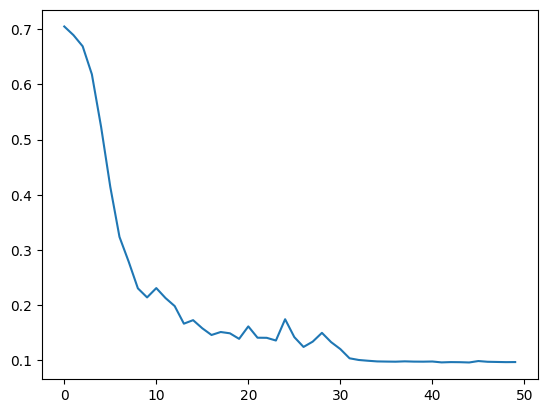

In [35]:
plt.plot(train_losses, label='Train loss')

In [36]:
print(val_losses)

[0.6911727414756524, 0.6848598054197969, 0.6785076123769166, 0.6538063795840154, 0.7268654972803398, 0.7748591782616787, 0.8209544175960979, 0.915149341841213, 0.8479815418602991, 0.8799505277735288, 1.0789703941736064, 0.9256409523917026, 0.9997603175092916, 1.1095747366303303, 1.202946738141482, 0.7996844854511198, 1.2501265382180449, 1.2493648323856417, 1.1011383274539572, 1.2585476768798516, 1.0733110721482606, 1.2993006750208433, 1.0849417208648118, 1.3679191985579788, 1.2059420664779474, 1.0706922534059307, 1.3682128855439484, 1.1180855294720071, 1.312000685539402, 1.146625010205097, 1.2577414239039186, 1.4068547946507814, 1.4602201268321178, 1.5621431000897141, 1.6009937632279319, 1.6184627833913585, 1.6944091212554055, 1.7635739709510179, 1.7551186895761333, 1.7882199502382121, 1.8219594193286583, 1.8263855190550695, 1.8700367642230675, 1.8953619863166185, 1.9288861028483657, 1.963022136785945, 1.9354261540975728, 2.04124018891913, 1.9906192519625678, 2.012006396641497]


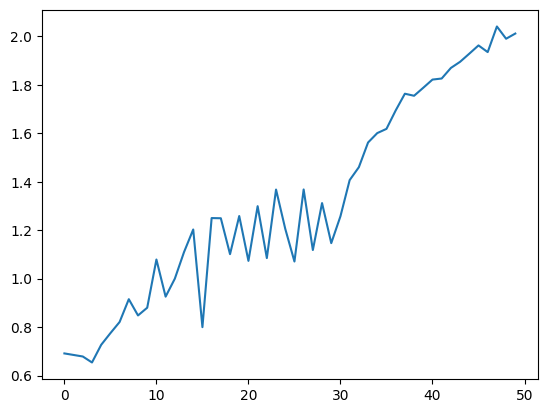

In [37]:
plt.plot(val_losses, label='Val loss')